## 1. Φόρτωση Βιβλιοθηκών

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Ρυθμίσεις για καλύτερη απεικόνιση
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

## 2. Φόρτωση Δεδομένων

In [103]:
# Φόρτωση του dataset
df = pd.read_csv('project_cluster.csv')

print(f"Διαστάσεις dataset: {df.shape}")
print(f"\nΠρώτες 5 γραμμές:")
df.head()

Διαστάσεις dataset: (2000, 17)

Πρώτες 5 γραμμές:


,Booking_ID,number.of.adults,number.of.children,number.of.weekend.nights,number.of.week.nights,type.of.meal,car.parking.space,room.type,lead.time,market.segment.type,repeated,P.C,P.not.C,average.price,special.requests,date.of.reservation,booking.status
0,BID19169,2,0,1,0,Meal Plan 1,0,Room_Type 1,0,Online,0,0,0,115.0,1,10/8/2017,Not_Canceled
1,BID26830,2,0,1,4,Meal Plan 1,0,Room_Type 1,11,Online,0,0,0,90.0,2,8/17/2017,Canceled
2,BID00278,1,0,2,1,Meal Plan 1,0,Room_Type 1,33,Online,0,0,0,82.9,2,5/3/2018,Not_Canceled
3,BID22091,2,0,0,1,Meal Plan 2,0,Room_Type 1,55,Offline,0,0,0,104.0,0,6/4/2018,Not_Canceled
4,BID17706,2,1,0,2,Meal Plan 1,0,Room_Type 1,138,Online,0,0,0,139.5,1,9/8/2018,Not_Canceled


In [104]:
# Γενικές πληροφορίες
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                2000 non-null   object 
 1   number.of.adults          2000 non-null   int64  
 2   number.of.children        2000 non-null   int64  
 3   number.of.weekend.nights  2000 non-null   int64  
 4   number.of.week.nights     2000 non-null   int64  
 5   type.of.meal              2000 non-null   object 
 6   car.parking.space         2000 non-null   int64  
 7   room.type                 2000 non-null   object 
 8   lead.time                 2000 non-null   int64  
 9   market.segment.type       2000 non-null   object 
 10  repeated                  2000 non-null   int64  
 11  P.C                       2000 non-null   int64  
 12  P.not.C                   2000 non-null   int64  
 13  average.price             2000 non-null   float64
 14  special.

In [105]:
# Έλεγχος για missing values
print("Missing values ανά στήλη:")
df.isnull().sum()

Missing values ανά στήλη:


Booking_ID                  0
number.of.adults            0
number.of.children          0
number.of.weekend.nights    0
number.of.week.nights       0
type.of.meal                0
car.parking.space           0
room.type                   0
lead.time                   0
market.segment.type         0
repeated                    0
P.C                         0
P.not.C                     0
average.price               0
special.requests            0
date.of.reservation         0
booking.status              0
dtype: int64

## 3. Feature Engineering

Δημιουργία νέων μεταβλητών σύμφωνα με το `notes.md`.

In [106]:
# Δημιουργία αντιγράφου για το preprocessing
df_processed = df.copy()

# 1. Total Guests
df_processed['Total_Guests'] = df_processed['number.of.adults'] + df_processed['number.of.children']

# 2. Is_Family (binary)
df_processed['Is_Family'] = (df_processed['number.of.children'] > 0).astype(int)

# 3. Total Nights
df_processed['Total_Nights'] = df_processed['number.of.weekend.nights'] + df_processed['number.of.week.nights']

# 4. Cancellation Ratio (για returning customers)
df_processed['Cancellation_Ratio'] = (df_processed['P.C'] + 1) / (df_processed['P.not.C'] + df_processed['P.C'] + 2)

# 5. Price per Person
df_processed['Price_per_Person'] = df_processed['average.price'] / df_processed['Total_Guests']
# Αντιμετώπιση περιπτώσεων με 0 guests (αν υπάρχουν)
df_processed['Price_per_Person'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 6. Arrival Month (από date.of.reservation + lead.time)
# Συνάρτηση για διόρθωση μη έγκυρων ημερομηνιών
def fix_invalid_date(date_str):
    """Προσπαθεί να διορθώσει μη έγκυρες ημερομηνίες μειώνοντας την ημέρα κατά 1"""
    try:
        return pd.to_datetime(date_str)
    except:
        # Προσπάθεια να αναλύσουμε την ημερομηνία χειροκίνητα
        try:
            date_str = str(date_str)
            # Έλεγχος για μορφή M/D/YYYY
            if '/' in date_str:
                parts = date_str.split('/')
                month, day, year = int(parts[0]), int(parts[1]), int(parts[2])
            # Έλεγχος για μορφή YYYY-M-D ή YYYY-MM-DD
            elif '-' in date_str:
                parts = date_str.split('-')
                year, month, day = int(parts[0]), int(parts[1]), int(parts[2])
            else:
                return pd.NaT
            
            # Προσπαθούμε να δημιουργήσουμε την ημερομηνία, μειώνοντας την ημέρα αν χρειάζεται
            while day > 0:
                try:
                    return pd.Timestamp(year=year, month=month, day=day)
                except:
                    day -= 1
        except:
            pass
        return pd.NaT

# Εφαρμογή της διόρθωσης
df_processed['date.of.reservation'] = df_processed['date.of.reservation'].apply(fix_invalid_date)

# Υπολογισμός Arrival Date και παράγωγων μεταβλητών
df_processed['Arrival_Date'] = df_processed['date.of.reservation'] + pd.to_timedelta(df_processed['lead.time'], unit='D')
df_processed['Arrival_Month'] = df_processed['Arrival_Date'].dt.month
df_processed['Arrival_Year'] = df_processed['Arrival_Date'].dt.year
df_processed['Reservation_Weekday'] = df_processed['date.of.reservation'].dt.dayofweek

# Έλεγχος για ημερομηνίες που δεν μπόρεσαν να διορθωθούν
invalid_dates = df_processed['date.of.reservation'].isna().sum()
if invalid_dates > 0:
    print(f"Προσοχή: {invalid_dates} ημερομηνίες δεν μπόρεσαν να διορθωθούν")
else:
    print("Όλες οι ημερομηνίες διορθώθηκαν επιτυχώς!")

print("Νέες μεταβλητές δημιουργήθηκαν επιτυχώς!")
print(f"\nΝέες διαστάσεις: {df_processed.shape}")

Όλες οι ημερομηνίες διορθώθηκαν επιτυχώς!
Νέες μεταβλητές δημιουργήθηκαν επιτυχώς!

Νέες διαστάσεις: (2000, 26)


In [107]:
# Εμφάνιση των νέων features
new_features = ['Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 
                'Price_per_Person', 'Arrival_Month', 'Arrival_Year', 'Reservation_Weekday']
df_processed[new_features].head()

,Total_Guests,Is_Family,Total_Nights,Cancellation_Ratio,Price_per_Person,Arrival_Month,Arrival_Year,Reservation_Weekday
0,2,0,1,0.5,57.5,10,2017,6
1,2,0,5,0.5,45.0,8,2017,3
2,1,0,3,0.5,82.9,6,2018,3
3,2,0,1,0.5,52.0,7,2018,0
4,3,1,2,0.5,46.5,1,2019,5


## 4. Αφαίρεση Περιττών Μεταβλητών

In [108]:
# Αποθήκευση του booking.status για μετέπειτα αξιολόγηση
booking_status = df_processed['booking.status'].copy()

# Μεταβλητές προς αφαίρεση
columns_to_drop = ['Booking_ID', 'booking.status', 'date.of.reservation', 'Arrival_Date']
df_processed = df_processed.drop(columns=columns_to_drop)

print(f"Διαστάσεις μετά την αφαίρεση: {df_processed.shape}")
print(f"\nΥπόλοιπες στήλες: {df_processed.columns.tolist()}")

Διαστάσεις μετά την αφαίρεση: (2000, 22)

Υπόλοιπες στήλες: ['number.of.adults', 'number.of.children', 'number.of.weekend.nights', 'number.of.week.nights', 'type.of.meal', 'car.parking.space', 'room.type', 'lead.time', 'market.segment.type', 'repeated', 'P.C', 'P.not.C', 'average.price', 'special.requests', 'Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 'Price_per_Person', 'Arrival_Month', 'Arrival_Year', 'Reservation_Weekday']


## 5. One-Hot Encoding για Κατηγορικές Μεταβλητές

In [109]:
# Κατηγορικές μεταβλητές
categorical_features = ['type.of.meal', 'room.type', 'market.segment.type']

print("Μοναδικές τιμές κατηγορικών μεταβλητών:")
for col in categorical_features:
    print(f"\n{col}: {df_processed[col].unique()}")

Μοναδικές τιμές κατηγορικών μεταβλητών:

type.of.meal: ['Meal Plan 1' 'Meal Plan 2' 'Not Selected' 'Meal Plan 3']

room.type: ['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 7'
 'Room_Type 3' 'Room_Type 5']

market.segment.type: ['Online' 'Offline' 'Corporate' 'Complementary' 'Aviation']


In [110]:
# One-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

print(f"Διαστάσεις μετά το encoding: {df_encoded.shape}")
print(f"\nΌλες οι στήλες:")
print(df_encoded.columns.tolist())

Διαστάσεις μετά το encoding: (2000, 32)

Όλες οι στήλες:
['number.of.adults', 'number.of.children', 'number.of.weekend.nights', 'number.of.week.nights', 'car.parking.space', 'lead.time', 'repeated', 'P.C', 'P.not.C', 'average.price', 'special.requests', 'Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 'Price_per_Person', 'Arrival_Month', 'Arrival_Year', 'Reservation_Weekday', 'type.of.meal_Meal Plan 2', 'type.of.meal_Meal Plan 3', 'type.of.meal_Not Selected', 'room.type_Room_Type 2', 'room.type_Room_Type 3', 'room.type_Room_Type 4', 'room.type_Room_Type 5', 'room.type_Room_Type 6', 'room.type_Room_Type 7', 'market.segment.type_Complementary', 'market.segment.type_Corporate', 'market.segment.type_Offline', 'market.segment.type_Online']


In [111]:
# Έλεγχος για NaN values
print("Missing values μετά το preprocessing:")
print(df_encoded.isnull().sum().sum())

# Αν υπάρχουν NaN, συμπληρώνουμε με τη μέση τιμή
if df_encoded.isnull().sum().sum() > 0:
    print("\nΣυμπλήρωση NaN με μέση τιμή...")
    df_encoded = df_encoded.fillna(df_encoded.mean())

Missing values μετά το preprocessing:
0


In [112]:
# Τελικό dataset για clustering
print("Τελικό dataset έτοιμο για clustering:")
print(f"Shape: {df_encoded.shape}")
df_encoded.head()

Τελικό dataset έτοιμο για clustering:
Shape: (2000, 32)


,number.of.adults,number.of.children,number.of.weekend.nights,number.of.week.nights,car.parking.space,lead.time,repeated,P.C,P.not.C,average.price,...,room.type_Room_Type 2,room.type_Room_Type 3,room.type_Room_Type 4,room.type_Room_Type 5,room.type_Room_Type 6,room.type_Room_Type 7,market.segment.type_Complementary,market.segment.type_Corporate,market.segment.type_Offline,market.segment.type_Online
0,2,0,1,0,0,0,0,0,0,115.0,...,False,False,False,False,False,False,False,False,False,True
1,2,0,1,4,0,11,0,0,0,90.0,...,False,False,False,False,False,False,False,False,False,True
2,1,0,2,1,0,33,0,0,0,82.9,...,False,False,False,False,False,False,False,False,False,True
3,2,0,0,1,0,55,0,0,0,104.0,...,False,False,False,False,False,False,False,False,True,False
4,2,1,0,2,0,138,0,0,0,139.5,...,False,False,False,False,False,False,False,False,False,True


## 6. Αποθήκευση Επεξεργασμένων Δεδομένων

In [113]:
# Αποθήκευση
df_encoded.to_csv('processed_data.csv', index=False)
print("Τα επεξεργασμένα δεδομένα αποθηκεύτηκαν στο 'processed_data.csv'")

Τα επεξεργασμένα δεδομένα αποθηκεύτηκαν στο 'processed_data.csv'


## 7. Ιστογράμματα για Κάθε Μεταβλητή

Δημιουργία ιστογραμμάτων για όλες τις αριθμητικές μεταβλητές (ένα plot ανά figure).

In [114]:
# Επιλογή μόνο των αριθμητικών μεταβλητών (χωρίς τις one-hot encoded)
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns.tolist()

print(f"Αριθμητικές μεταβλητές: {len(numeric_columns)}")
print(numeric_columns)

Αριθμητικές μεταβλητές: 19
['number.of.adults', 'number.of.children', 'number.of.weekend.nights', 'number.of.week.nights', 'car.parking.space', 'lead.time', 'repeated', 'P.C', 'P.not.C', 'average.price', 'special.requests', 'Total_Guests', 'Is_Family', 'Total_Nights', 'Cancellation_Ratio', 'Price_per_Person', 'Arrival_Month', 'Arrival_Year', 'Reservation_Weekday']


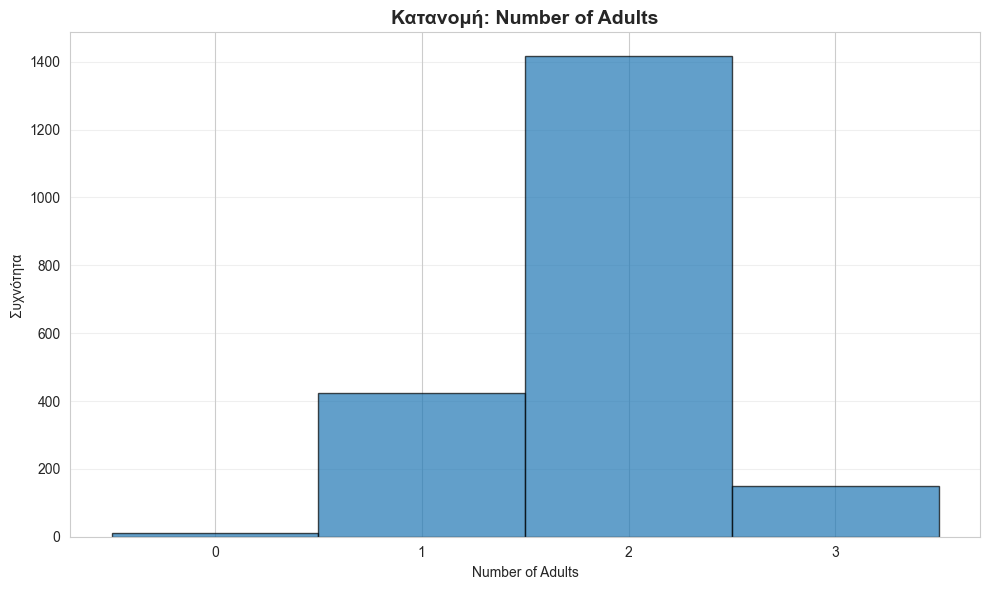

In [115]:
# Ιστόγραμμα για number.of.adults
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['number.of.adults'].unique())
bins = [x - 0.5 for x in range(int(df_processed['number.of.adults'].max()) + 2)]
plt.hist(df_processed['number.of.adults'], bins=bins, edgecolor='black', alpha=0.7, align='mid')
plt.title('Κατανομή: Number of Adults', fontsize=14, fontweight='bold')
plt.xlabel('Number of Adults')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

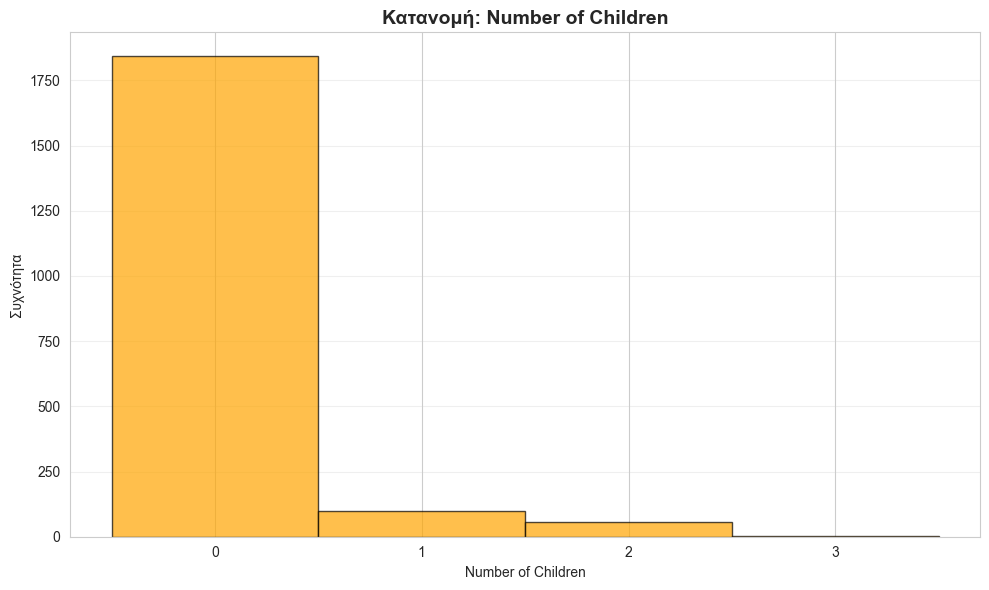

In [116]:
# Ιστόγραμμα για number.of.children
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['number.of.children'].unique())
bins = [x - 0.5 for x in range(int(df_processed['number.of.children'].max()) + 2)]
plt.hist(df_processed['number.of.children'], bins=bins, edgecolor='black', alpha=0.7, color='orange', align='mid')
plt.title('Κατανομή: Number of Children', fontsize=14, fontweight='bold')
plt.xlabel('Number of Children')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

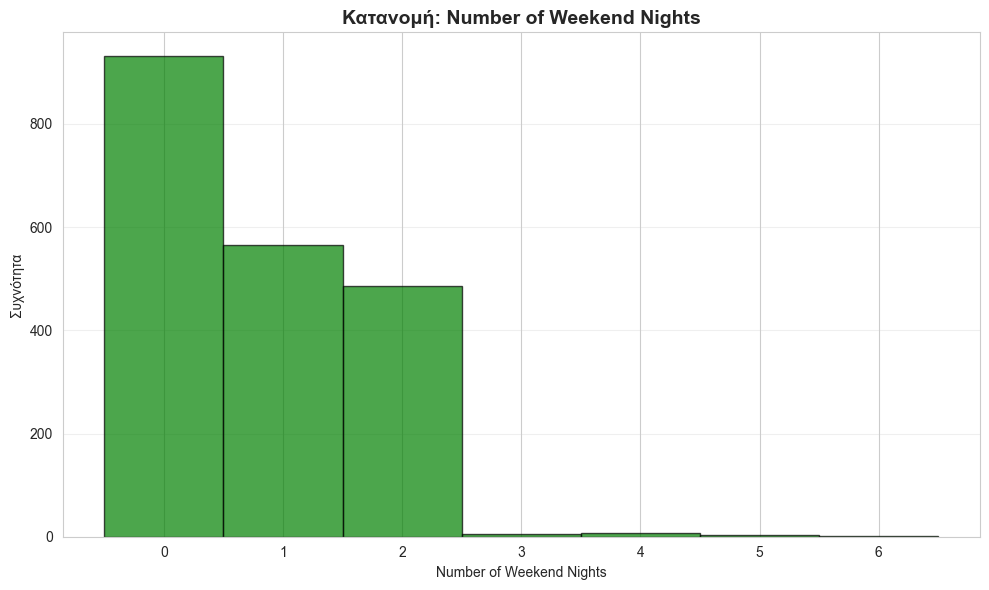

In [117]:
# Ιστόγραμμα για number.of.weekend.nights
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['number.of.weekend.nights'].unique())
bins = [x - 0.5 for x in range(int(df_processed['number.of.weekend.nights'].max()) + 2)]
plt.hist(df_processed['number.of.weekend.nights'], bins=bins, edgecolor='black', alpha=0.7, color='green', align='mid')
plt.title('Κατανομή: Number of Weekend Nights', fontsize=14, fontweight='bold')
plt.xlabel('Number of Weekend Nights')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

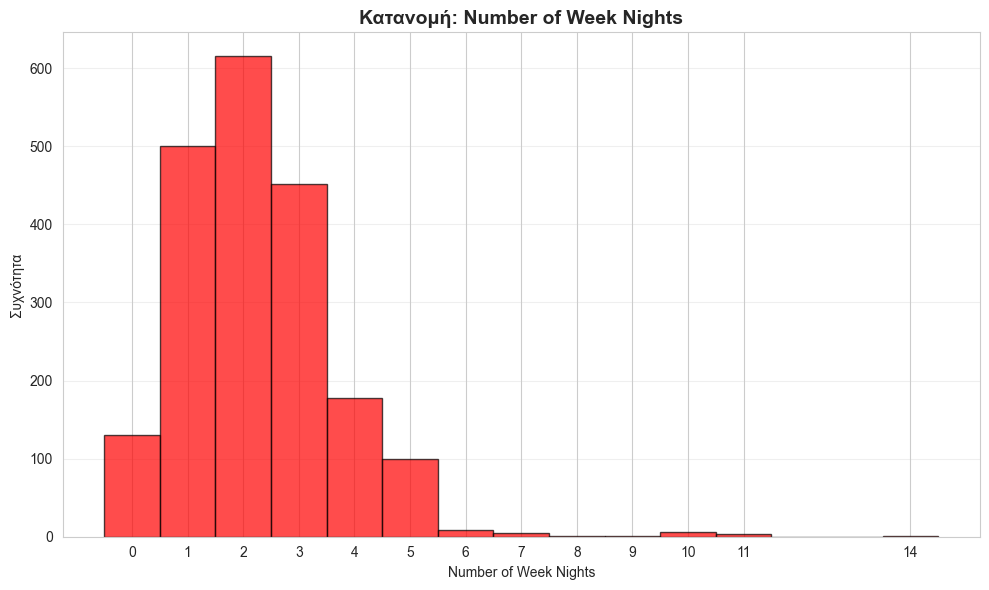

In [118]:
# Ιστόγραμμα για number.of.week.nights
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['number.of.week.nights'].unique())
bins = [x - 0.5 for x in range(int(df_processed['number.of.week.nights'].max()) + 2)]
plt.hist(df_processed['number.of.week.nights'], bins=bins, edgecolor='black', alpha=0.7, color='red', align='mid')
plt.title('Κατανομή: Number of Week Nights', fontsize=14, fontweight='bold')
plt.xlabel('Number of Week Nights')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

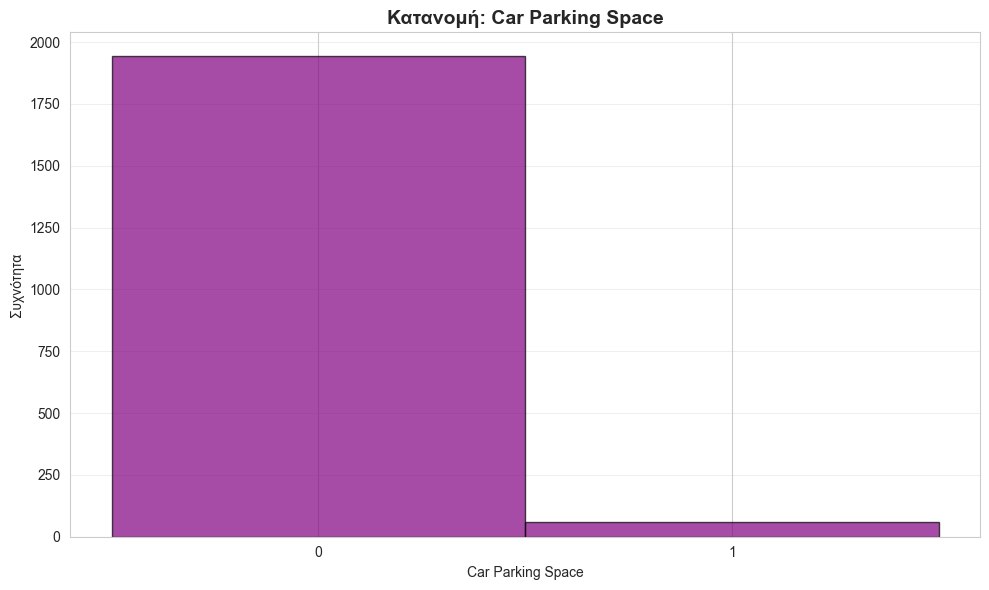

In [119]:
# Ιστόγραμμα για car.parking.space
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['car.parking.space'].unique())
bins = [x - 0.5 for x in range(int(df_processed['car.parking.space'].max()) + 2)]
plt.hist(df_processed['car.parking.space'], bins=bins, edgecolor='black', alpha=0.7, color='purple', align='mid')
plt.title('Κατανομή: Car Parking Space', fontsize=14, fontweight='bold')
plt.xlabel('Car Parking Space')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

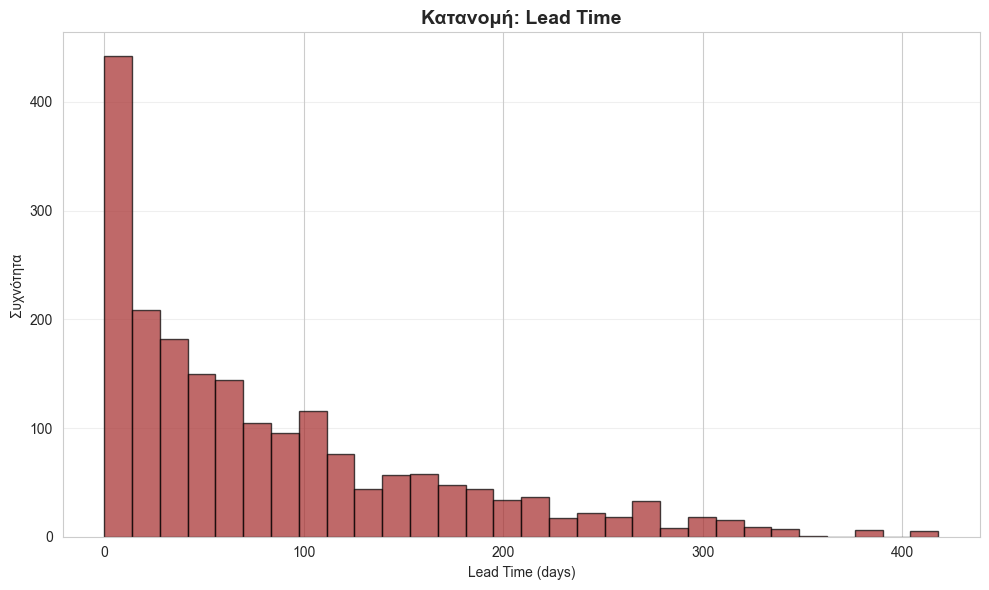

In [120]:
# Ιστόγραμμα για lead.time
plt.figure(figsize=(10, 6))
plt.hist(df_processed['lead.time'], bins=30, edgecolor='black', alpha=0.7, color='brown')
plt.title('Κατανομή: Lead Time', fontsize=14, fontweight='bold')
plt.xlabel('Lead Time (days)')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

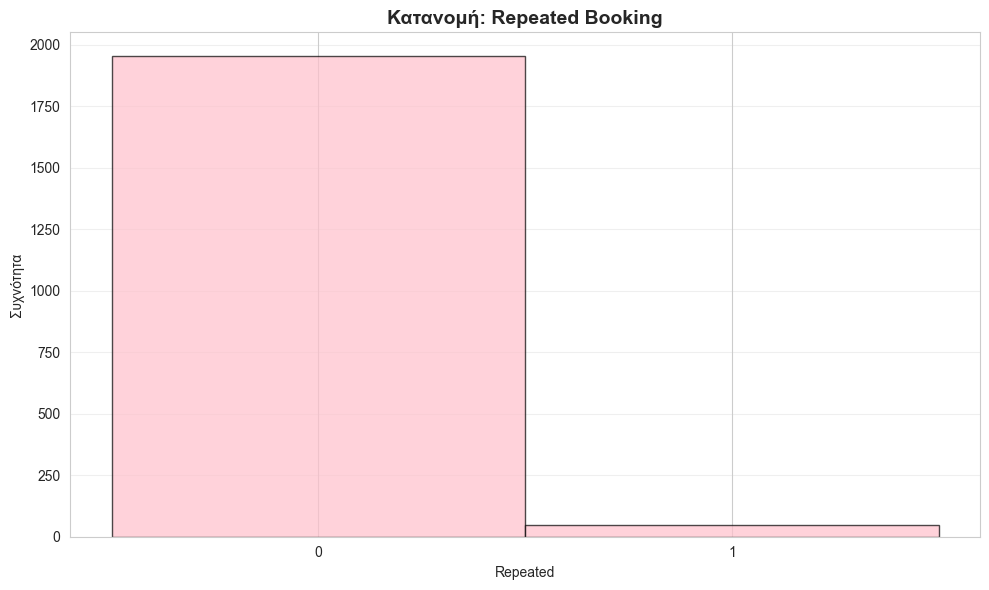

In [121]:
# Ιστόγραμμα για repeated
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['repeated'].unique())
bins = [x - 0.5 for x in range(int(df_processed['repeated'].max()) + 2)]
plt.hist(df_processed['repeated'], bins=bins, edgecolor='black', alpha=0.7, color='pink', align='mid')
plt.title('Κατανομή: Repeated Booking', fontsize=14, fontweight='bold')
plt.xlabel('Repeated')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

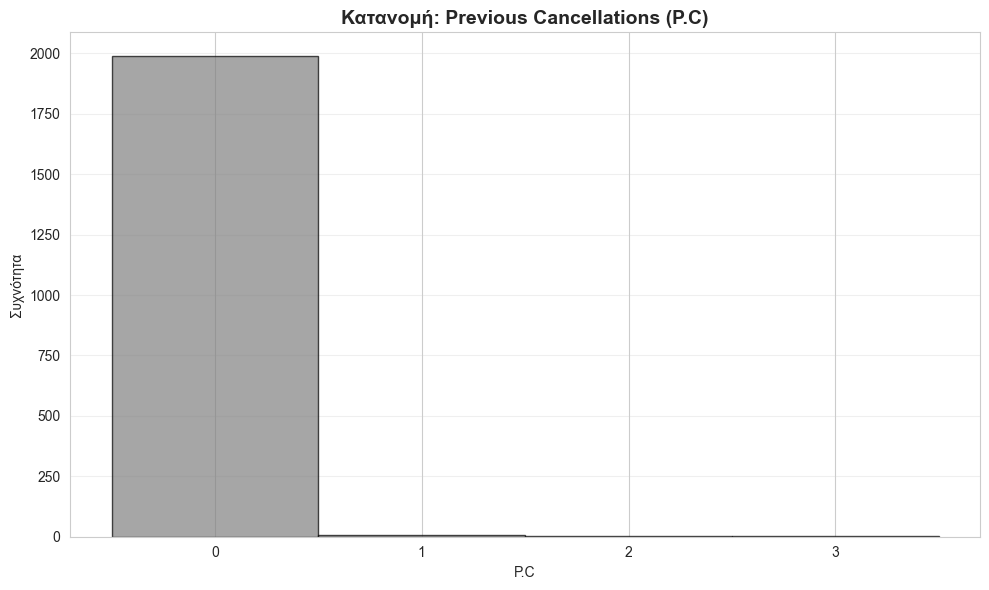

In [122]:
# Ιστόγραμμα για P.C
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['P.C'].unique())
bins = [x - 0.5 for x in range(int(df_processed['P.C'].max()) + 2)]
plt.hist(df_processed['P.C'], bins=bins, edgecolor='black', alpha=0.7, color='gray', align='mid')
plt.title('Κατανομή: Previous Cancellations (P.C)', fontsize=14, fontweight='bold')
plt.xlabel('P.C')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

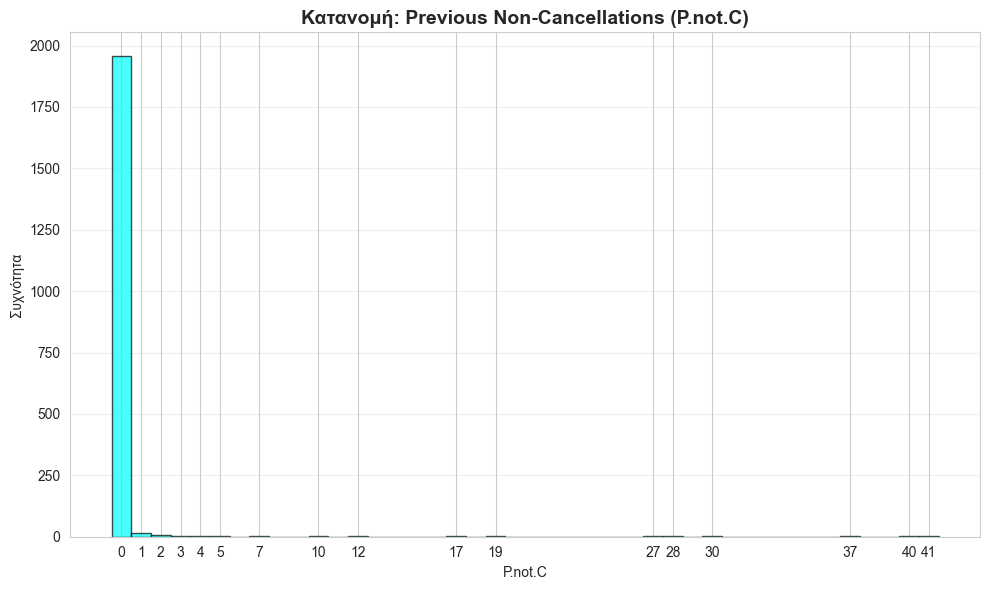

In [123]:
# Ιστόγραμμα για P.not.C
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['P.not.C'].unique())
bins = [x - 0.5 for x in range(int(df_processed['P.not.C'].max()) + 2)]
plt.hist(df_processed['P.not.C'], bins=bins, edgecolor='black', alpha=0.7, color='cyan', align='mid')
plt.title('Κατανομή: Previous Non-Cancellations (P.not.C)', fontsize=14, fontweight='bold')
plt.xlabel('P.not.C')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

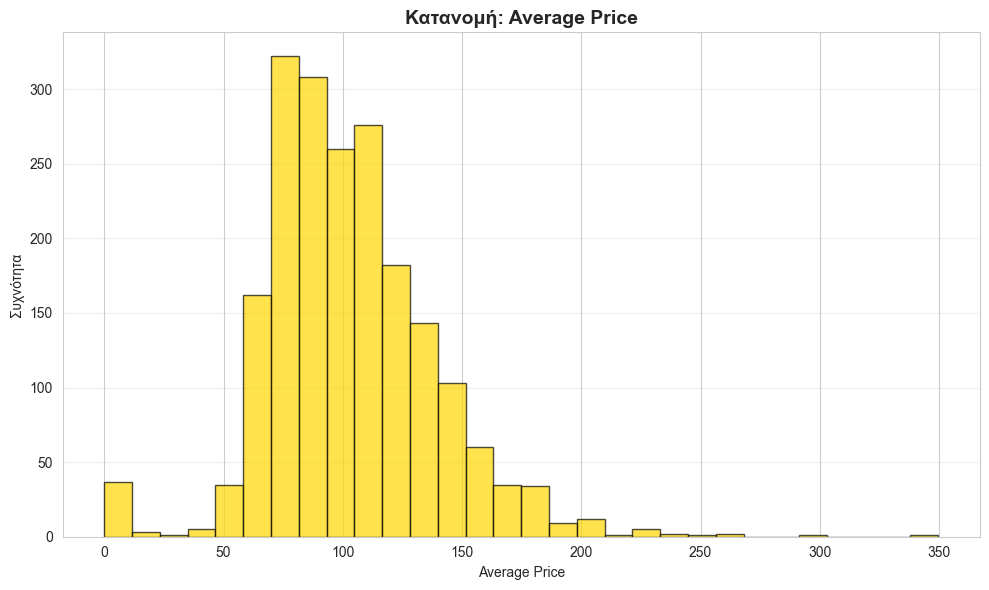

In [124]:
# Ιστόγραμμα για average.price
plt.figure(figsize=(10, 6))
plt.hist(df_processed['average.price'], bins=30, edgecolor='black', alpha=0.7, color='gold')
plt.title('Κατανομή: Average Price', fontsize=14, fontweight='bold')
plt.xlabel('Average Price')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

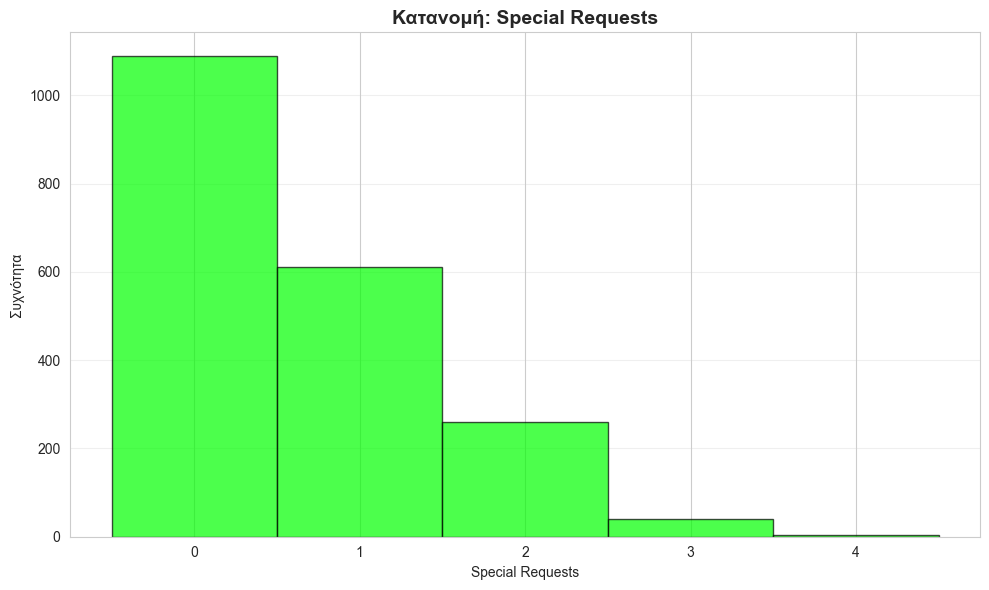

In [125]:
# Ιστόγραμμα για special.requests
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['special.requests'].unique())
bins = [x - 0.5 for x in range(int(df_processed['special.requests'].max()) + 2)]
plt.hist(df_processed['special.requests'], bins=bins, edgecolor='black', alpha=0.7, color='lime', align='mid')
plt.title('Κατανομή: Special Requests', fontsize=14, fontweight='bold')
plt.xlabel('Special Requests')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

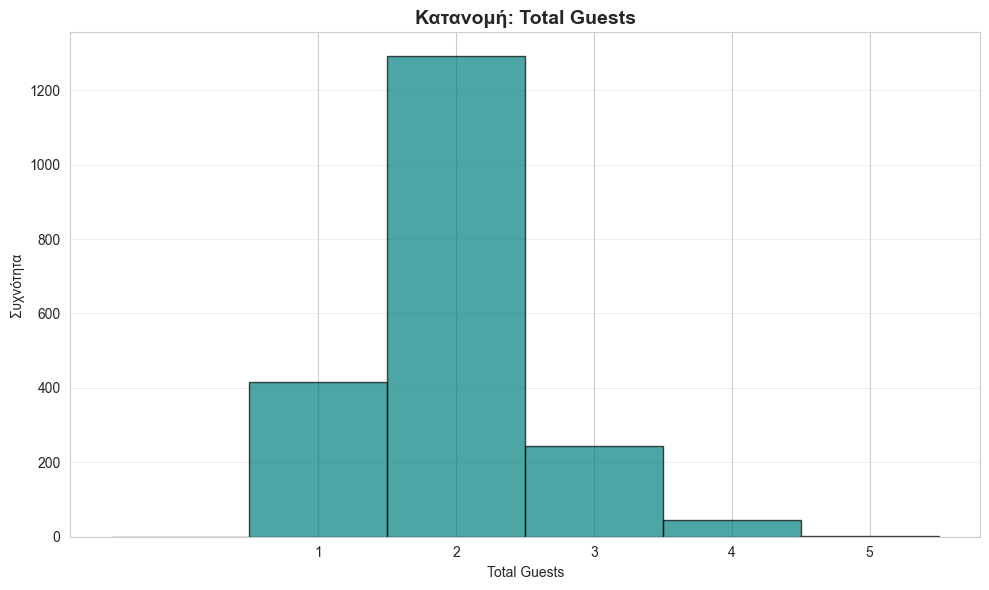

In [126]:
# Ιστόγραμμα για Total_Guests
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['Total_Guests'].unique())
bins = [x - 0.5 for x in range(int(df_processed['Total_Guests'].max()) + 2)]
plt.hist(df_processed['Total_Guests'], bins=bins, edgecolor='black', alpha=0.7, color='teal', align='mid')
plt.title('Κατανομή: Total Guests', fontsize=14, fontweight='bold')
plt.xlabel('Total Guests')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

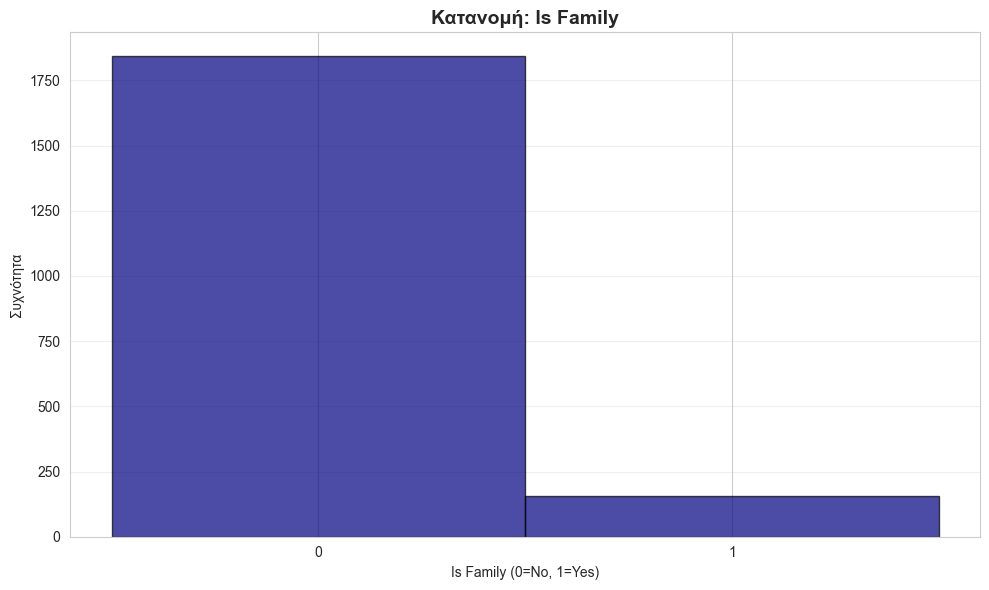

In [127]:
# Ιστόγραμμα για Is_Family
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['Is_Family'].unique())
bins = [x - 0.5 for x in range(int(df_processed['Is_Family'].max()) + 2)]
plt.hist(df_processed['Is_Family'], bins=bins, edgecolor='black', alpha=0.7, color='navy', align='mid')
plt.title('Κατανομή: Is Family', fontsize=14, fontweight='bold')
plt.xlabel('Is Family (0=No, 1=Yes)')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)   
plt.tight_layout()
plt.show()

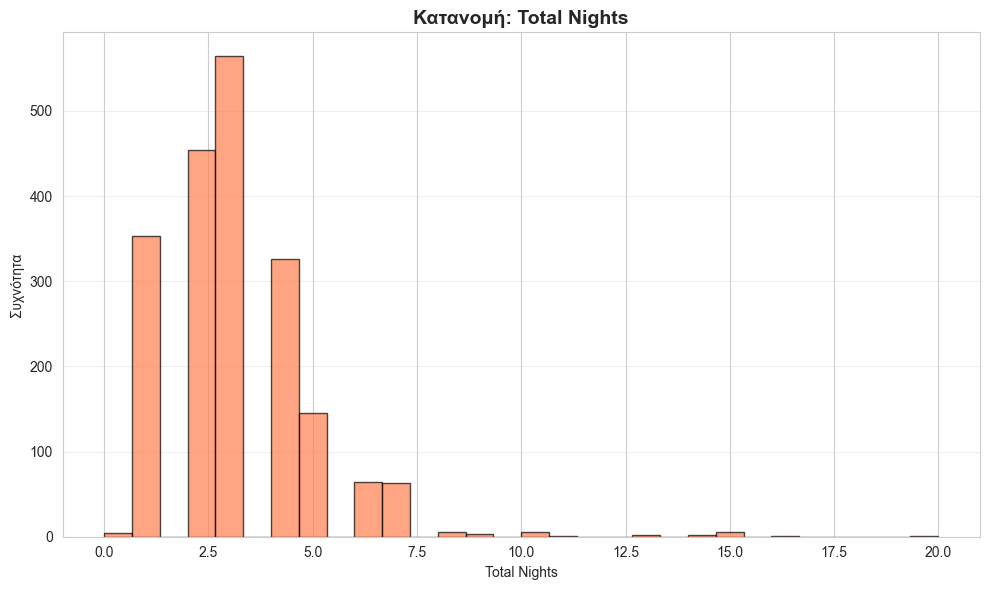

In [128]:
# Ιστόγραμμα για Total_Nights
plt.figure(figsize=(10, 6))
plt.hist(df_processed['Total_Nights'], bins=30, edgecolor='black', alpha=0.7, color='coral')
plt.title('Κατανομή: Total Nights', fontsize=14, fontweight='bold')
plt.xlabel('Total Nights')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

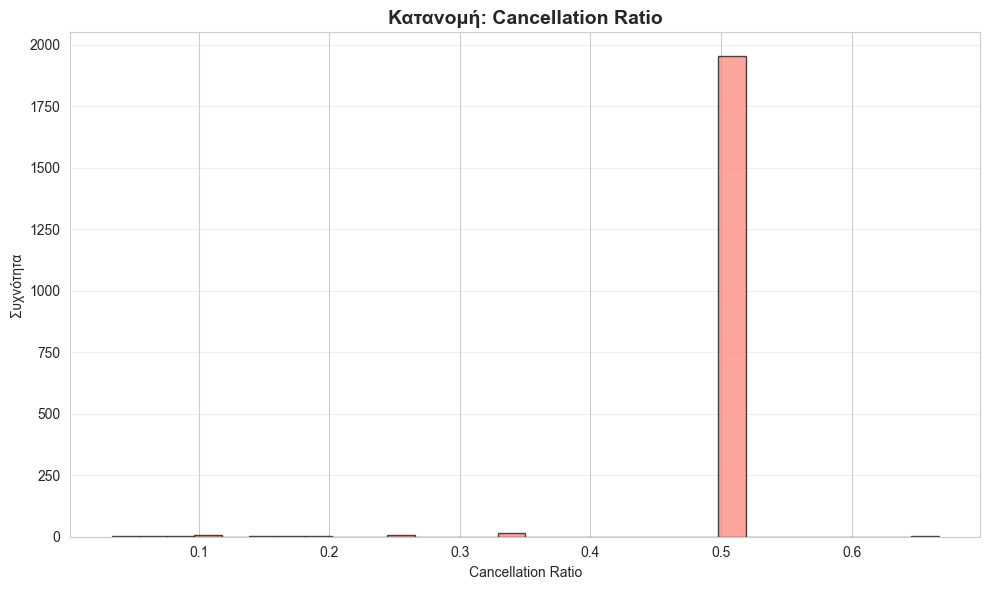

In [129]:
# Ιστόγραμμα για Cancellation_Ratio
plt.figure(figsize=(10, 6))
plt.hist(df_processed['Cancellation_Ratio'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
plt.title('Κατανομή: Cancellation Ratio', fontsize=14, fontweight='bold')
plt.xlabel('Cancellation Ratio')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

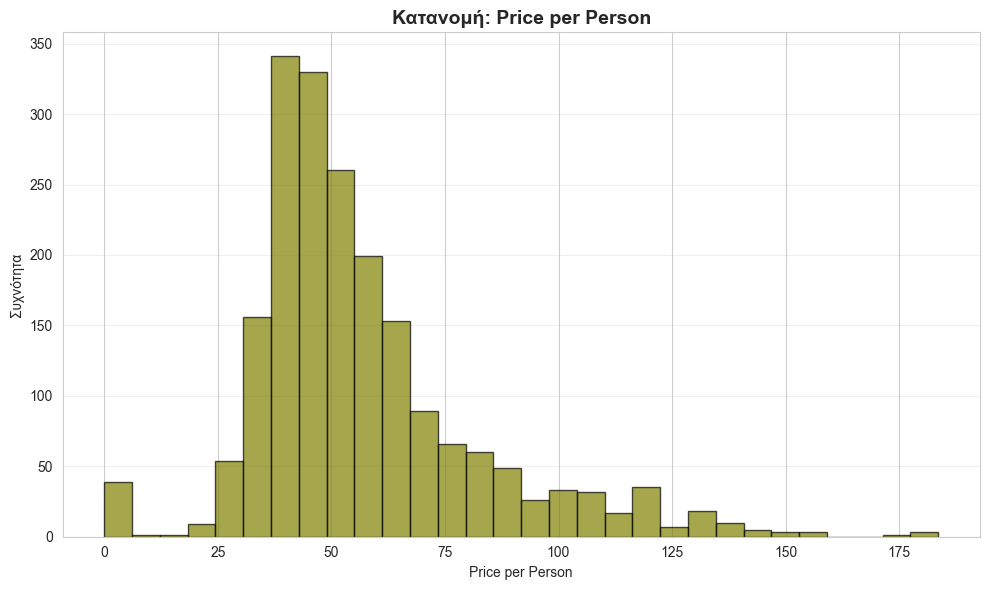

In [130]:
# Ιστόγραμμα για Price_per_Person
plt.figure(figsize=(10, 6))
plt.hist(df_processed['Price_per_Person'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='olive')
plt.title('Κατανομή: Price per Person', fontsize=14, fontweight='bold')
plt.xlabel('Price per Person')
plt.ylabel('Συχνότητα')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

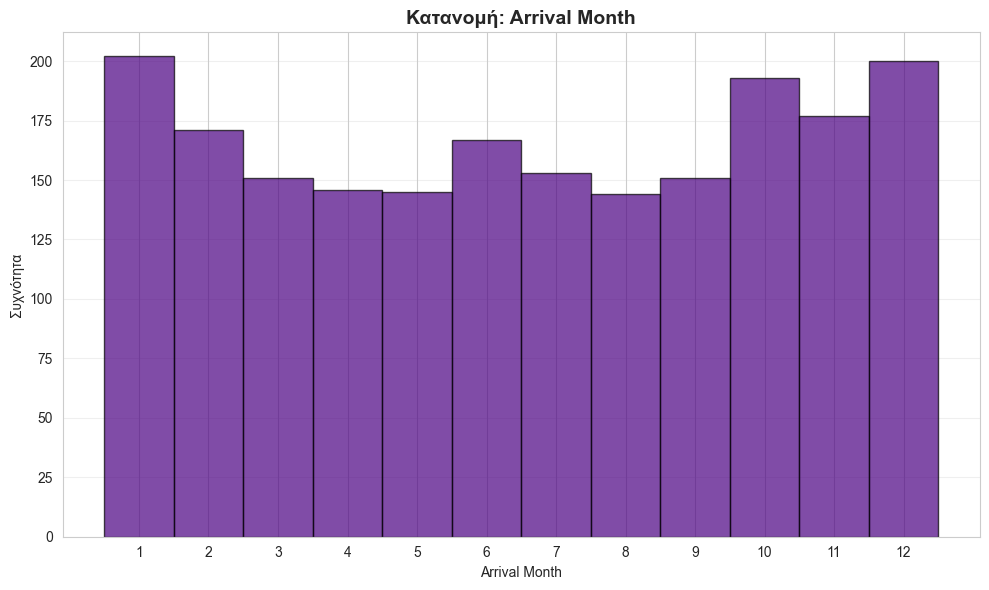

In [131]:
# Ιστόγραμμα για Arrival_Month
plt.figure(figsize=(10, 6))
bins = [x - 0.5 for x in range(1, 14)]  # Μήνες από 1 έως 12
plt.hist(df_processed['Arrival_Month'], bins=bins, edgecolor='black', alpha=0.7, color='indigo', align='mid')
plt.title('Κατανομή: Arrival Month', fontsize=14, fontweight='bold')
plt.xlabel('Arrival Month')
plt.ylabel('Συχνότητα')
plt.xticks(range(1, 13))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

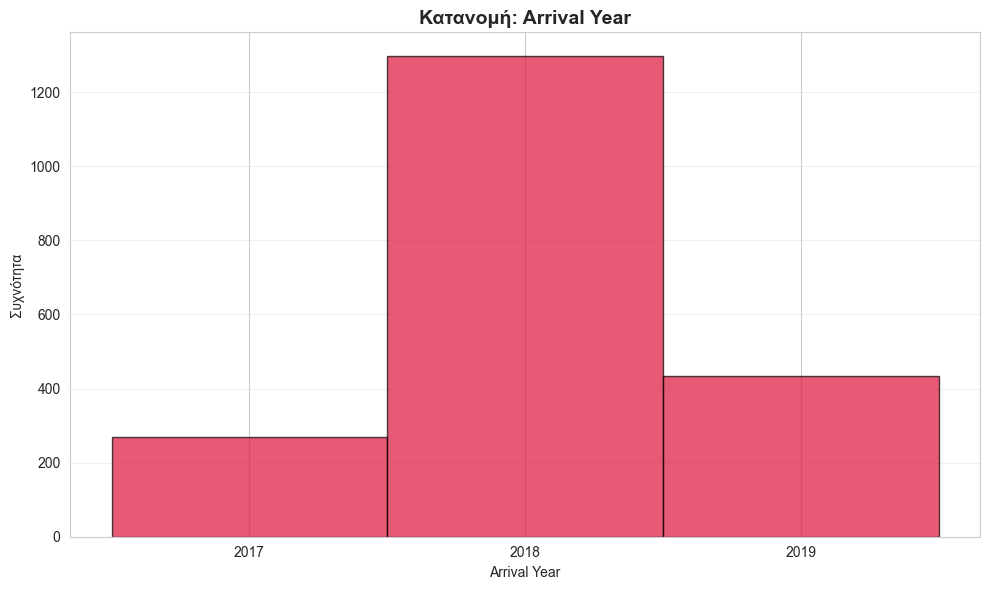

In [132]:
# Ιστόγραμμα για Arrival_Year
plt.figure(figsize=(10, 6))
unique_vals = sorted(df_processed['Arrival_Year'].unique())
bins = [x - 0.5 for x in range(int(df_processed['Arrival_Year'].min()), int(df_processed['Arrival_Year'].max()) + 2)]
plt.hist(df_processed['Arrival_Year'], bins=bins, edgecolor='black', alpha=0.7, color='crimson', align='mid')
plt.title('Κατανομή: Arrival Year', fontsize=14, fontweight='bold')
plt.xlabel('Arrival Year')
plt.ylabel('Συχνότητα')
plt.xticks(unique_vals)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

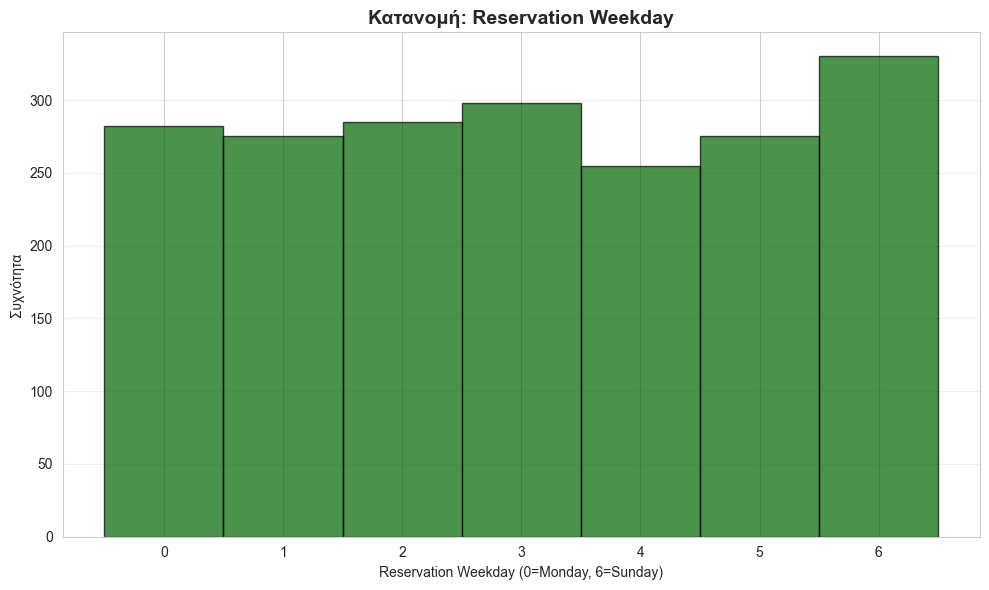

In [133]:
# Ιστόγραμμα για Reservation_Weekday
plt.figure(figsize=(10, 6))
bins = [x - 0.5 for x in range(8)]  # Ημέρες από 0 έως 6
plt.hist(df_processed['Reservation_Weekday'], bins=bins, edgecolor='black', alpha=0.7, color='darkgreen', align='mid')
plt.title('Κατανομή: Reservation Weekday', fontsize=14, fontweight='bold')
plt.xlabel('Reservation Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Συχνότητα')
plt.xticks(range(7))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Clustering Analysis

Εφαρμογή K-Means και Hierarchical Clustering με αξιολόγηση μέσω διαφόρων μετρικών.

In [134]:
# Βιβλιοθήκες για clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

print("Βιβλιοθήκες clustering φορτώθηκαν επιτυχώς!")

Βιβλιοθήκες clustering φορτώθηκαν επιτυχώς!


### 8.1 K-Means Clustering

In [135]:
# Προετοιμασία δεδομένων για clustering
X = df_encoded.values

# Εύρος k
k_range = range(2, 11)

# Αποθήκευση μετρικών
kmeans_inertia = []
kmeans_silhouette = []
kmeans_labels_dict = {}

print("Εκτέλεση K-Means για k = 2 έως 10...")
for k in k_range:
    print(f"K-Means με k={k}...", end=" ")
    
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Αποθήκευση labels
    kmeans_labels_dict[k] = labels
    
    # Inertia
    kmeans_inertia.append(kmeans.inertia_)
    
    # Silhouette Score
    silhouette = silhouette_score(X, labels)
    kmeans_silhouette.append(silhouette)
    
    print(f"✓ (Inertia: {kmeans.inertia_:.2f}, Silhouette: {silhouette:.4f})")

print("\nK-Means ολοκληρώθηκε!")

Εκτέλεση K-Means για k = 2 έως 10...
K-Means με k=2... ✓ (Inertia: 7792328.31, Silhouette: 0.5311)
K-Means με k=3... ✓ (Inertia: 5728065.69, Silhouette: 0.3826)
K-Means με k=4... ✓ (Inertia: 4444245.10, Silhouette: 0.3361)
K-Means με k=5... ✓ (Inertia: 3668104.56, Silhouette: 0.3294)
K-Means με k=6... ✓ (Inertia: 3268895.17, Silhouette: 0.3383)
K-Means με k=7... ✓ (Inertia: 4444245.10, Silhouette: 0.3361)
K-Means με k=5... ✓ (Inertia: 3668104.56, Silhouette: 0.3294)
K-Means με k=6... ✓ (Inertia: 3268895.17, Silhouette: 0.3383)
K-Means με k=7... ✓ (Inertia: 2985658.12, Silhouette: 0.3269)
K-Means με k=8... ✓ (Inertia: 2682088.05, Silhouette: 0.3438)
K-Means με k=9... ✓ (Inertia: 2985658.12, Silhouette: 0.3269)
K-Means με k=8... ✓ (Inertia: 2682088.05, Silhouette: 0.3438)
K-Means με k=9... ✓ (Inertia: 2414838.49, Silhouette: 0.3235)
K-Means με k=10... ✓ (Inertia: 2230376.62, Silhouette: 0.3123)

K-Means ολοκληρώθηκε!
✓ (Inertia: 2414838.49, Silhouette: 0.3235)
K-Means με k=10... ✓ (Inert

### 8.2 Hierarchical Clustering

In [136]:
# Αποθήκευση μετρικών για Hierarchical
hierarchical_silhouette = []
hierarchical_labels_dict = {}

print("Εκτέλεση Hierarchical Clustering για k = 2 έως 10...")
for k in k_range:
    print(f"Hierarchical με k={k}...", end=" ")
    
    # Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hierarchical.fit_predict(X)
    
    # Αποθήκευση labels
    hierarchical_labels_dict[k] = labels
    
    # Silhouette Score
    silhouette = silhouette_score(X, labels)
    hierarchical_silhouette.append(silhouette)
    
    print(f"✓ (Silhouette: {silhouette:.4f})")

print("\nHierarchical Clustering ολοκληρώθηκε!")

Εκτέλεση Hierarchical Clustering για k = 2 έως 10...
Hierarchical με k=2... ✓ (Silhouette: 0.5350)
Hierarchical με k=3... ✓ (Silhouette: 0.5350)
Hierarchical με k=3... ✓ (Silhouette: 0.2732)
Hierarchical με k=4... ✓ (Silhouette: 0.2732)
Hierarchical με k=4... ✓ (Silhouette: 0.2726)
Hierarchical με k=5... ✓ (Silhouette: 0.2726)
Hierarchical με k=5... ✓ (Silhouette: 0.2784)
Hierarchical με k=6... ✓ (Silhouette: 0.2784)
Hierarchical με k=6... ✓ (Silhouette: 0.2929)
Hierarchical με k=7... ✓ (Silhouette: 0.2929)
Hierarchical με k=7... ✓ (Silhouette: 0.2741)
Hierarchical με k=8... ✓ (Silhouette: 0.2741)
Hierarchical με k=8... ✓ (Silhouette: 0.2866)
Hierarchical με k=9... ✓ (Silhouette: 0.2866)
Hierarchical με k=9... ✓ (Silhouette: 0.2713)
Hierarchical με k=10... ✓ (Silhouette: 0.2713)
Hierarchical με k=10... ✓ (Silhouette: 0.2782)

Hierarchical Clustering ολοκληρώθηκε!
✓ (Silhouette: 0.2782)

Hierarchical Clustering ολοκληρώθηκε!


### 8.3 Υπολογισμός NMI και ARI

Σύγκριση K-Means και Hierarchical Clustering με NMI (Normalized Mutual Information) και ARI (Adjusted Rand Index).

In [137]:
# Υπολογισμός NMI και ARI μεταξύ K-Means και Hierarchical
nmi_scores = []
ari_scores = []

print("Υπολογισμός NMI και ARI μεταξύ K-Means και Hierarchical...")
for k in k_range:
    kmeans_labels = kmeans_labels_dict[k]
    hierarchical_labels = hierarchical_labels_dict[k]
    
    # NMI
    nmi = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)
    nmi_scores.append(nmi)
    
    # ARI
    ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
    ari_scores.append(ari)
    
    print(f"k={k}: NMI={nmi:.4f}, ARI={ari:.4f}")

print("\nΥπολογισμοί ολοκληρώθηκαν!")

Υπολογισμός NMI και ARI μεταξύ K-Means και Hierarchical...
k=2: NMI=0.8037, ARI=0.8870
k=3: NMI=0.5881, ARI=0.6622
k=4: NMI=0.5666, ARI=0.5365
k=5: NMI=0.6626, ARI=0.6218
k=6: NMI=0.6790, ARI=0.6017
k=7: NMI=0.6645, ARI=0.5793
k=8: NMI=0.6761, ARI=0.5711
k=9: NMI=0.6517, ARI=0.4973
k=10: NMI=0.6545, ARI=0.4976

Υπολογισμοί ολοκληρώθηκαν!


### 8.4 Οπτικοποίηση Αποτελεσμάτων

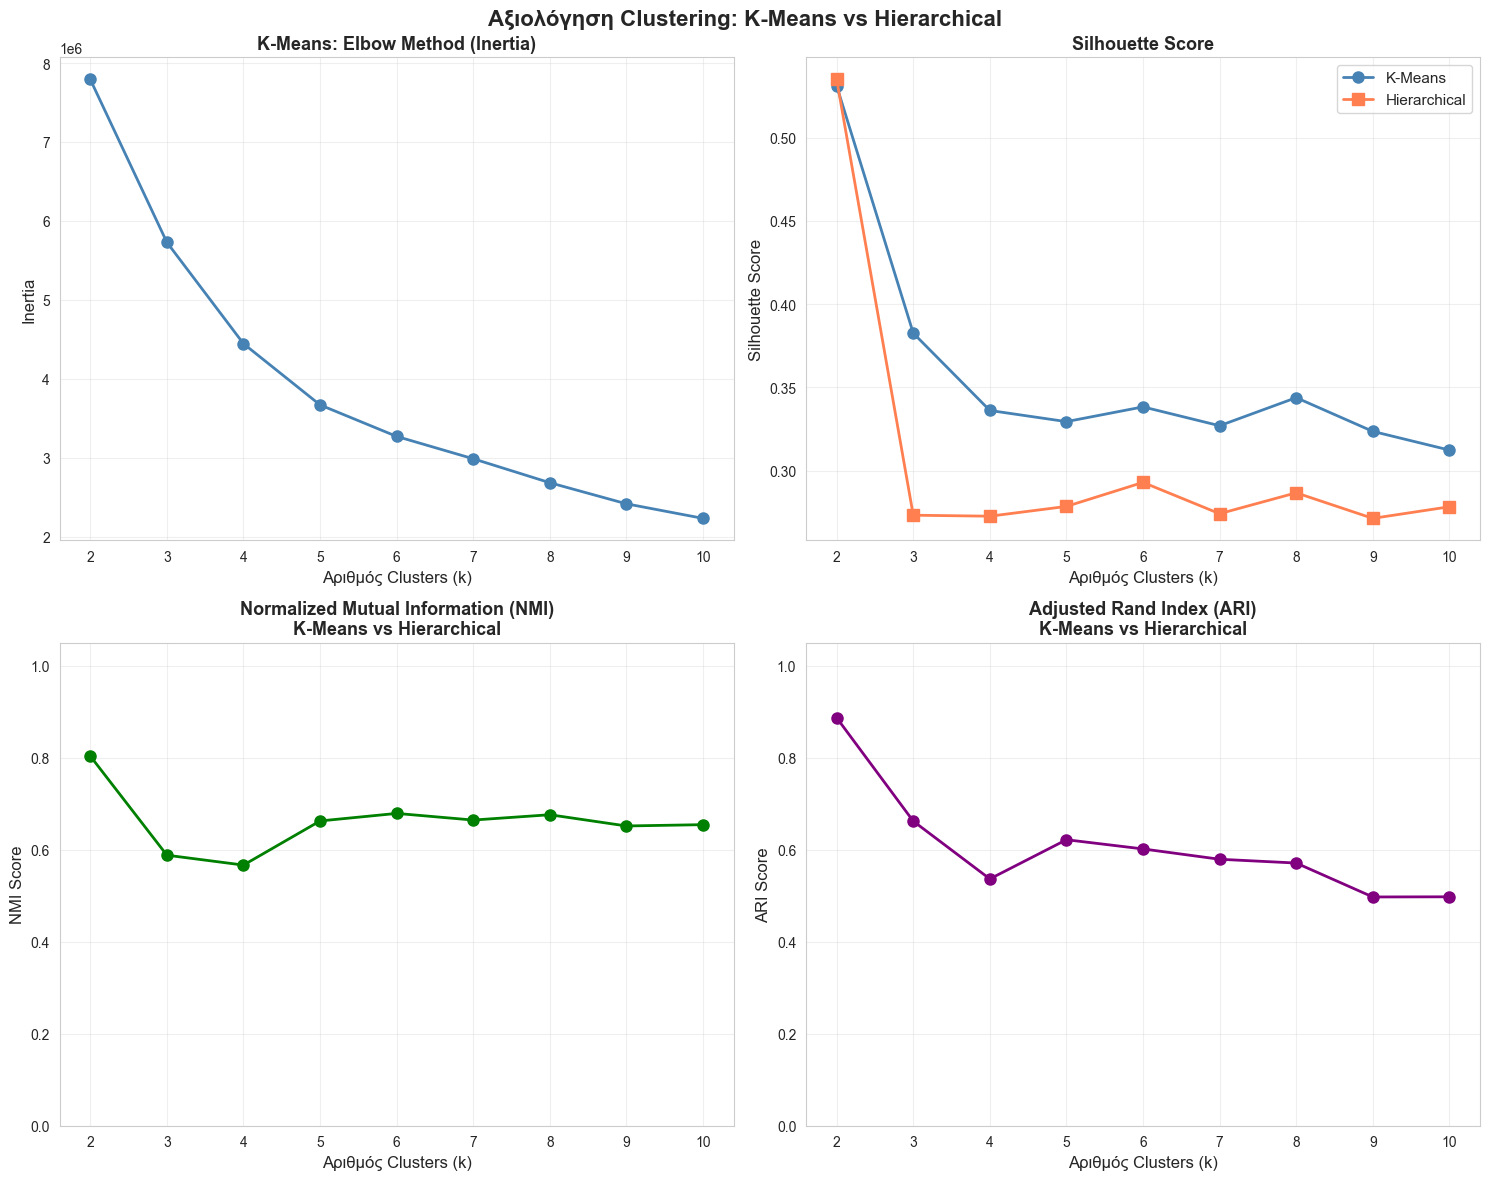


ΣΥΝΟΨΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

Βέλτιστο k για K-Means (Silhouette): k=2 (Score: 0.5311)
Βέλτιστο k για Hierarchical (Silhouette): k=2 (Score: 0.5350)

Μέγιστη συμφωνία (NMI): k=2 (Score: 0.8037)
Μέγιστη συμφωνία (ARI): k=2 (Score: 0.8870)


In [138]:
# Δημιουργία 2x2 subplots για όλες τις μετρικές
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Αξιολόγηση Clustering: K-Means vs Hierarchical', fontsize=16, fontweight='bold')

k_values = list(k_range)

# 1. Inertia (Elbow Method) - Μόνο για K-Means
axes[0, 0].plot(k_values, kmeans_inertia, 'o-', color='steelblue', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Αριθμός Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('K-Means: Elbow Method (Inertia)', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_values)

# 2. Silhouette Score - Σύγκριση
axes[0, 1].plot(k_values, kmeans_silhouette, 'o-', label='K-Means', color='steelblue', linewidth=2, markersize=8)
axes[0, 1].plot(k_values, hierarchical_silhouette, 's-', label='Hierarchical', color='coral', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Αριθμός Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_values)

# 3. NMI (Normalized Mutual Information)
axes[1, 0].plot(k_values, nmi_scores, 'o-', color='green', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Αριθμός Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('NMI Score', fontsize=12)
axes[1, 0].set_title('Normalized Mutual Information (NMI)\nK-Means vs Hierarchical', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_values)
axes[1, 0].set_ylim([0, 1.05])

# 4. ARI (Adjusted Rand Index)
axes[1, 1].plot(k_values, ari_scores, 'o-', color='purple', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Αριθμός Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('ARI Score', fontsize=12)
axes[1, 1].set_title('Adjusted Rand Index (ARI)\nK-Means vs Hierarchical', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_values)
axes[1, 1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ΣΥΝΟΨΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ")
print("="*60)
print(f"\nΒέλτιστο k για K-Means (Silhouette): k={k_values[kmeans_silhouette.index(max(kmeans_silhouette))]} (Score: {max(kmeans_silhouette):.4f})")
print(f"Βέλτιστο k για Hierarchical (Silhouette): k={k_values[hierarchical_silhouette.index(max(hierarchical_silhouette))]} (Score: {max(hierarchical_silhouette):.4f})")
print(f"\nΜέγιστη συμφωνία (NMI): k={k_values[nmi_scores.index(max(nmi_scores))]} (Score: {max(nmi_scores):.4f})")
print(f"Μέγιστη συμφωνία (ARI): k={k_values[ari_scores.index(max(ari_scores))]} (Score: {max(ari_scores):.4f})")
print("="*60)